# 2D Uncertainty Estimation
For 2D Echo or Anti-Echo Reconstruction with MRAi and CS and 50% NUS recostraction with CS

In [1]:
import time
import numpy as np
import nmrglue as ng
import MRAi_2D as ma
import Proc_2D as pr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})

2024-09-25 03:51:08.947394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 03:51:18.013182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define the path (direction) of the Echo spectrum process in pipe format.
Here as an example, the path to US 2D H-N—TROSY spectrum of protein MALT1 is used. Then Echo, Anti-Echo and NUS spectra are prepared based on the US.

![US_Echo_Anti_NUS.png](Figs/US_Echo_Anti_NUS.png)

In [2]:
%%time
# Replace this path with your actual spectrum in nmrpipe format file.
spectrum_direction = "Spectra/Malt.ft2"
# Read the file with nmrglue.
dic , Ref = ng.pipe.read(spectrum_direction)

# Convert Ref spectrum to Echo spectrum 
Echo = pr.convertors.VE_to_E(Ref)
# Convert Ref spectrum to Anti-Echo spectrum 
Anti = pr.convertors.VE_to_AE(Ref)

# Prepare 50% NUS table
np.random.seed(0)
NUS_table = pr.NUS_sampler.NS(64,128,"PG")
# Convert Ref spectrum to NUS spectrum with NUS table
NUS = pr.convertors.US_to_NUS(Ref,NUS_table)

CPU times: user 91.9 ms, sys: 7.91 ms, total: 99.8 ms
Wall time: 99.8 ms


### Call the functions that run the trained network and CS for Echo, Anti-Echo, and NUS reconstruction
This section executes functions for processing using a trained network and performing compressed sensing (CS) reconstruction for Echo, Anti-Echo, and Non-Uniform Sampling (NUS) data.

In [4]:
%%time
# Path to the trained network model
DNN_dirc = "Trained_NN/Echo/"

# Echo Recostraction with MRAi
WNN_Echo = ma.Production.Echo_Rec(Echo,DNN_dirc+"EAE/")
# Anti-Echo Recostraction with MRAi
WNN_Anti = pr.convertors.flip(ma.Production.Echo_Rec(pr.convertors.flip(Anti),DNN_dirc+"EAE/"))

# Echo Recostraction with CS
CS_Echo = pr.CS.E_US(Echo,200)
# Anti-Echo Recostraction with CS
CS_Anti = pr.convertors.flip(pr.CS.E_US(pr.convertors.flip(Anti),200))
# 50% NUS Recostraction with CS
CS_NUS = pr.CS.NUS_US(NUS,NUS_table,200)

4/4 [==============================] - 0s 7ms/step
CPU times: user 2min 48s, sys: 18min 13s, total: 21min 2s
Wall time: 29.2 s


### Call the function with the default direction that runs the trained network for Uncertainty Estimation.

![Un_MRAi.png](Figs/Un_MRAi.png)

In [5]:
%%time
# Predict uncertainty for Echo Reconstruction using MRAi
WNN_Echo_Un = ma.Production.Uncertainty(Echo,DNN_dirc+"Un_WNN/")
# Predict uncertainty for Anti-Echo Reconstruction using MRAi
WNN_Anti_Un = pr.convertors.flip(ma.Production.Uncertainty(pr.convertors.flip(Anti),DNN_dirc+"Un_WNN/"))
# Predict uncertainty for Echo Reconstruction using CS
CS_Echo_Un = ma.Production.Uncertainty(Echo,DNN_dirc+"Un_CS/")
# Predict uncertainty for Anti-Echo Reconstruction using CS
CS_Anti_Un = pr.convertors.flip(ma.Production.Uncertainty(pr.convertors.flip(Anti),DNN_dirc+"Un_CS/"))
# Predict uncertainty for 50% NUS Reconstruction using CS
CS_NUS_Un = ma.Production.Uncertainty(NUS,DNN_dirc+"Un_CS_NUS/")

4/4 [==============================] - 0s 7ms/step
CPU times: user 3.45 s, sys: 387 ms, total: 3.83 s
Wall time: 3.97 s


### Plotting the spectra with predicted uncertainty in pink and actual error in red
This code plots the spectrum with two overlays.

CPU times: user 2.48 s, sys: 43 ms, total: 2.53 s
Wall time: 2.73 s


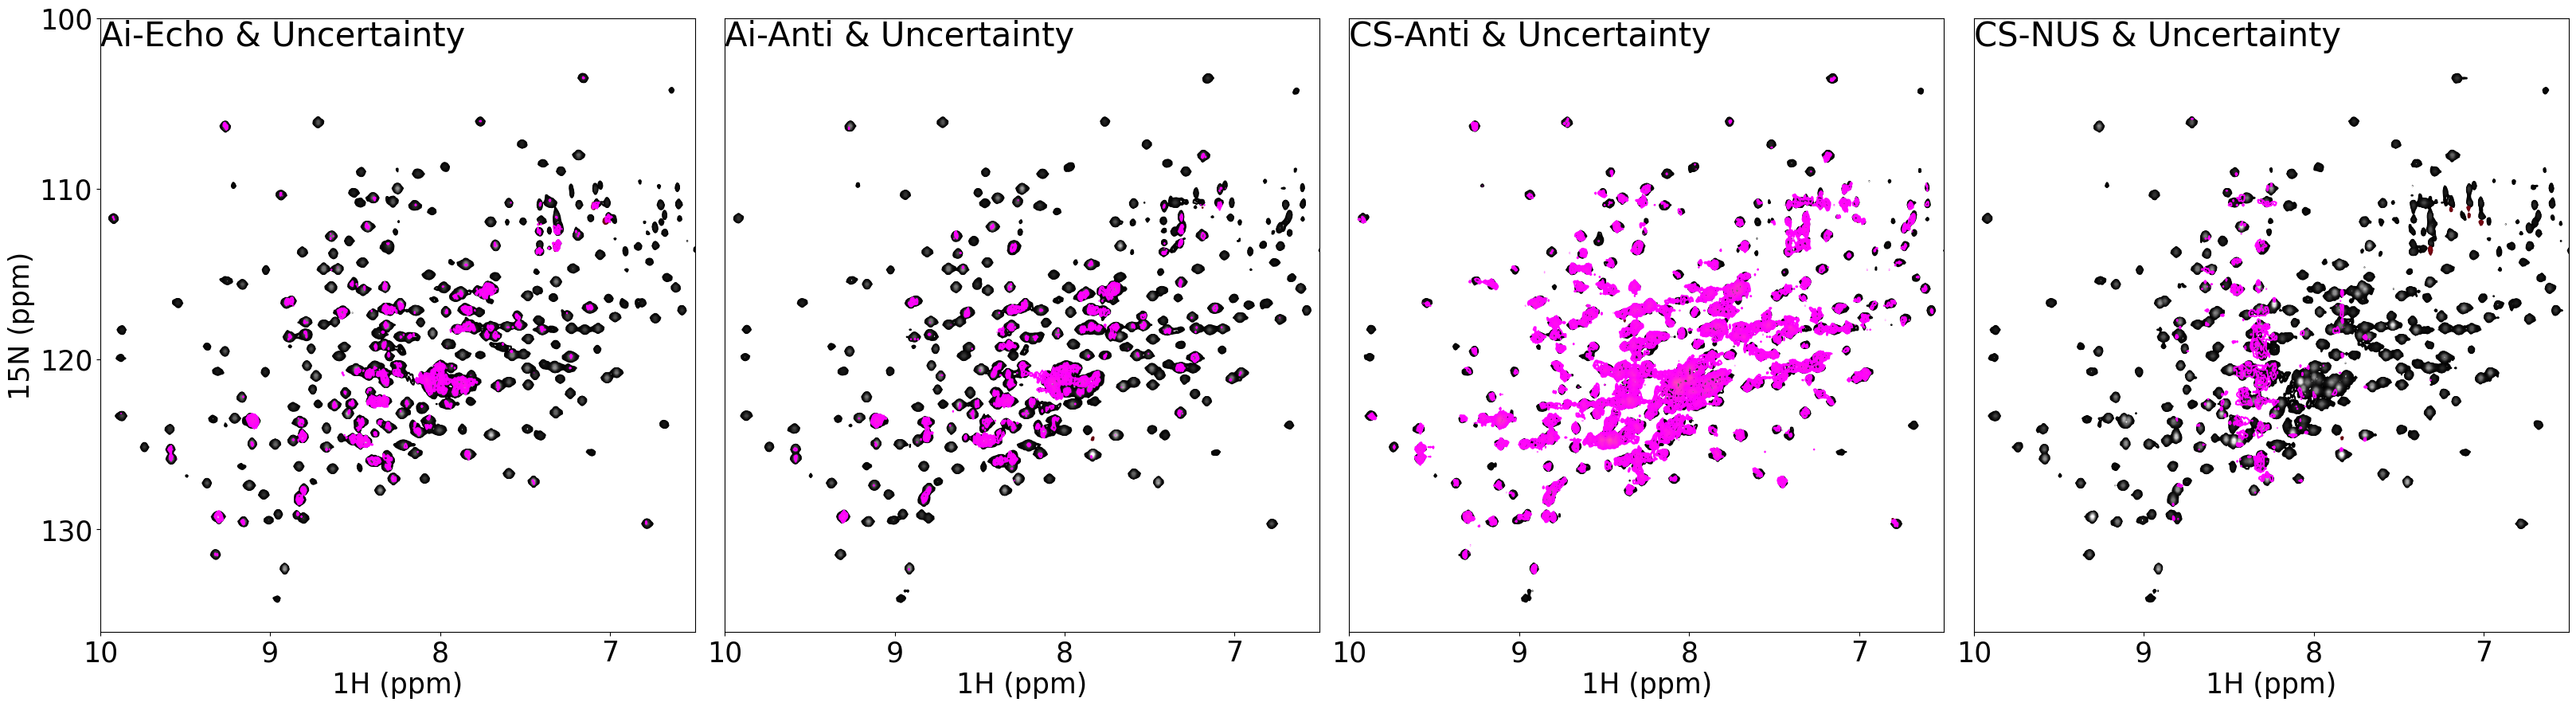

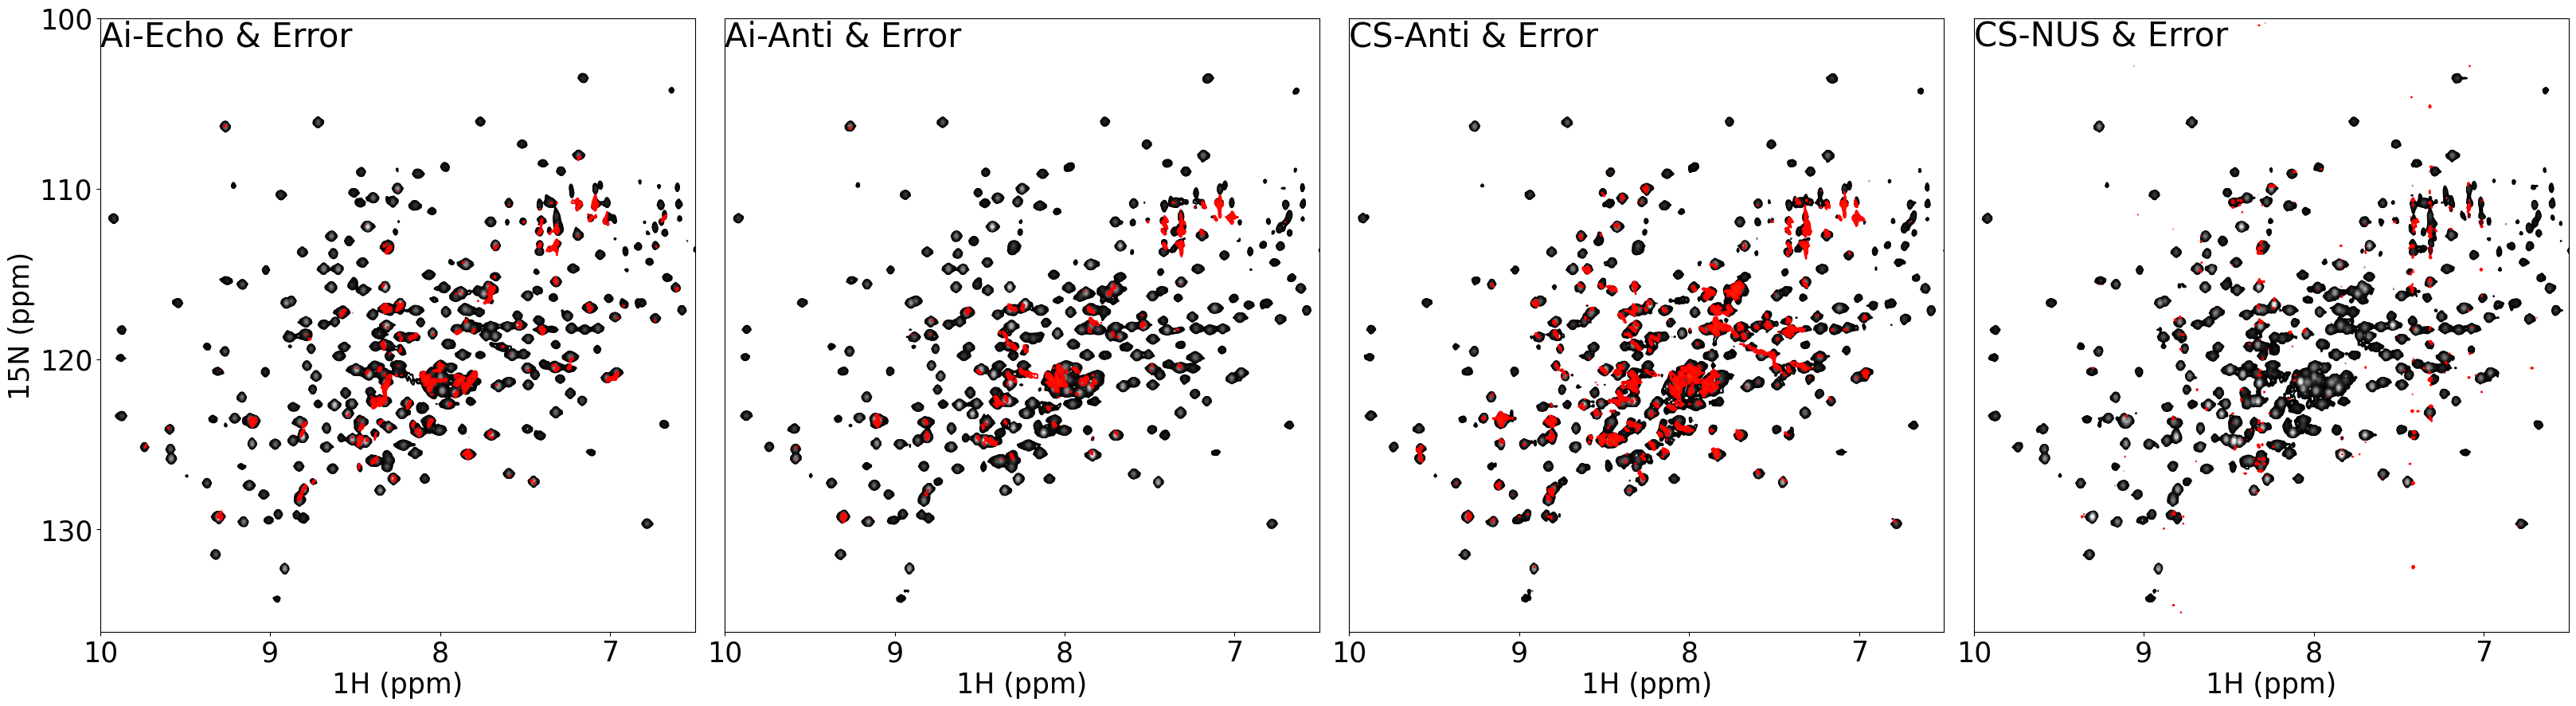

In [6]:
%%time
contours = {"Spectra/Ubi.ft2": [0.03,1.2,20] ,"Spectra/Azurin.ft2": [0.02,1.2,20],"Spectra/Tau.ft2": [0.04,1.2,20],
            "Spectra/Malt.ft2": [0.025,1.2,20],"Spectra/Data.ft2": [0.02,1.2,20]}
lims = {"Spectra/Ubi.ft2": [9.9,6,130,100],"Spectra/Azurin.ft2": [10,5.6,135,100],"Spectra/Tau.ft2": [8.5, 7.6,130, 105],
        "Spectra/Malt.ft2": [10, 6.5,136, 100],"Spectra/Data.ft2": [0.5,-0.5,0.5,-0.5]}

fig, ax = plt.subplots(1,4,figsize=(4*10,10))
cmap = [plt.cm.Greys_r,plt.cm.Reds_r]    #[+,-] contour map (colors to use for contours)
contour = contours.get(spectrum_direction)         #[contour level start value, scaling factor between contour level]
lim = lims.get(spectrum_direction)                 #[xlim from,xlim to,ylim from,ylim to]

pr.PLOTS.subp(ax[0],dic,WNN_Echo/np.max(Ref), "Ai-Echo & Uncertainty",
     contour,cmap,lim,2*WNN_Echo_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[1],dic,WNN_Anti/np.max(Ref), "Ai-Anti & Uncertainty",
      contour,cmap,lim,2*WNN_Anti_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[2],dic,CS_Anti/np.max(Ref),"CS-Anti & Uncertainty",
      contour,cmap,lim,2*CS_Anti_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[3],dic,CS_NUS/np.max(Ref),"CS-NUS & Uncertainty",
      contour,cmap,lim,4*CS_NUS_Un/np.max(Ref),plt.cm.spring)

ax[1].axes.yaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

fig, ax = plt.subplots(1,4,figsize=(4*10,10))

pr.PLOTS.subp(ax[0],dic,WNN_Echo/np.max(Ref), "Ai-Echo & Error",
     contour,cmap,lim,np.abs(WNN_Echo-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[1],dic,WNN_Anti/np.max(Ref), "Ai-Anti & Error",
     contour,cmap,lim,np.abs(WNN_Anti-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[2],dic,CS_Anti/np.max(Ref), "CS-Anti & Error",
     contour,cmap,lim,np.abs(CS_Anti-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[3],dic,CS_NUS/np.max(Ref), "CS-NUS & Error",
     contour,cmap,lim,2*np.abs(CS_NUS-Ref)/np.max(Ref),plt.cm.autumn)

ax[1].axes.yaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)


plt.subplots_adjust(wspace=0.05, hspace=0.05)

### Limit the spectra to a small region to score the quality of reconstructions quantitatively.
This process extracts a specific region of the spectra to focus on for quantitative evaluation of reconstruction quality. Adjust the region limits as necessary based on the spectrum.

In [7]:
%%time
limits = {"Spectra/Ubi.ft2": [800, 1500],"Spectra/Azurin.ft2": [250, 1800],"Spectra/Tau.ft2": [1100, 1330],
          "Spectra/Malt.ft2": [100, 800],"Spectra/Data.ft2":[1,4096]}
limit = limits.get(spectrum_direction)
dic_EX , Ref_R = ng.process.pipe_proc.ext(dic.copy(), Ref, x1= limit[0] , xn= limit[1])

dic_EX , WNN_Echo_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Echo, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Anti_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Anti, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Echo_Un_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Echo_Un, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Anti_Un_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Anti_Un, x1= limit[0] , xn= limit[1])

dic_EX , CS_Echo_R = ng.process.pipe_proc.ext(dic.copy(), CS_Echo, x1= limit[0] , xn= limit[1])
dic_EX , CS_Anti_R = ng.process.pipe_proc.ext(dic.copy(), CS_Anti, x1= limit[0] , xn= limit[1])
dic_EX , CS_Echo_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_Echo_Un, x1= limit[0] , xn= limit[1])
dic_EX , CS_Anti_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_Anti_Un, x1= limit[0] , xn= limit[1])

dic_EX , CS_NUS_R = ng.process.pipe_proc.ext(dic.copy(), CS_NUS, x1= limit[0] , xn= limit[1])
dic_EX , CS_NUS_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_NUS_Un, x1= limit[0] , xn= limit[1])


CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 3.11 ms


### Reference-free metric
This metric evaluates the quality of spectrum reconstructions without requiring a reference spectrum. It can be used to assess the accuracy of reconstructions.

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 33.2 ms


[Text(0, 0.5, '$\\sigma/S_{p_{max}}$')]

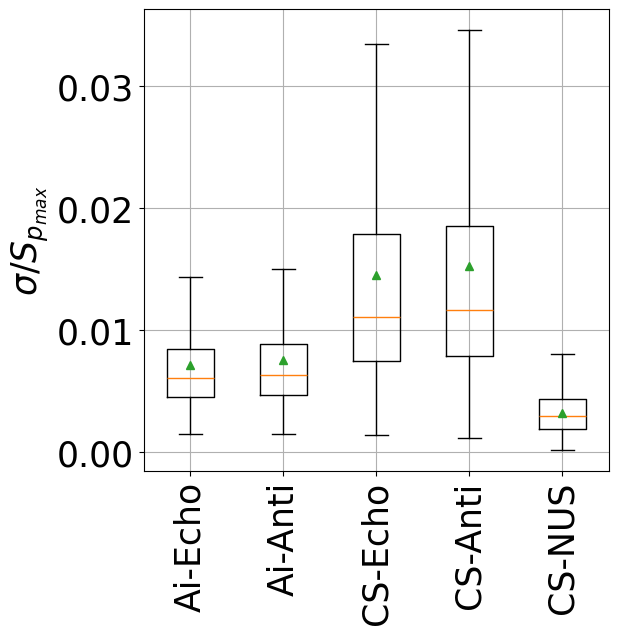

In [8]:
%%time
def Selected_Un(Uncer,Pred,Noise_threshold,RMSD_threshold=1):
    U = Uncer.flatten()/np.max(Pred)
    P = Pred.flatten()/np.max(Pred)
    return U[(np.abs(P)>Noise_threshold) & (np.abs(P)<=RMSD_threshold)]

threshold = 0.01
threshold_up = 1

Label = ['Ai-Echo','Ai-Anti','CS-Echo','CS-Anti','CS-NUS']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.boxplot([Selected_Un(WNN_Echo_Un_R,WNN_Echo_R,threshold,threshold_up),
           Selected_Un(WNN_Anti_Un_R,WNN_Anti_R,threshold,threshold_up),
           Selected_Un(CS_Echo_Un_R,CS_Echo_R,threshold,threshold_up),
           Selected_Un(CS_Anti_Un_R,CS_Anti_R,threshold,threshold_up),
           Selected_Un(CS_NUS_Un_R,CS_NUS_R,threshold,threshold_up)],
           showfliers=False, showmeans=True)
ax.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xticklabels(Label)
ax.grid()
ax.set(ylabel='$\sigma/S_{p_{max}}$')

### Reference-based metric
This metric is used to evaluate the quality of a reconstructed spectrum by comparing it to a known reference spectrum. The comparison can be made using different techniques, such as mean squared error (MSE), correlation, or other similarity metrics.


CPU times: user 39.9 ms, sys: 55.7 ms, total: 95.6 ms
Wall time: 31.7 ms


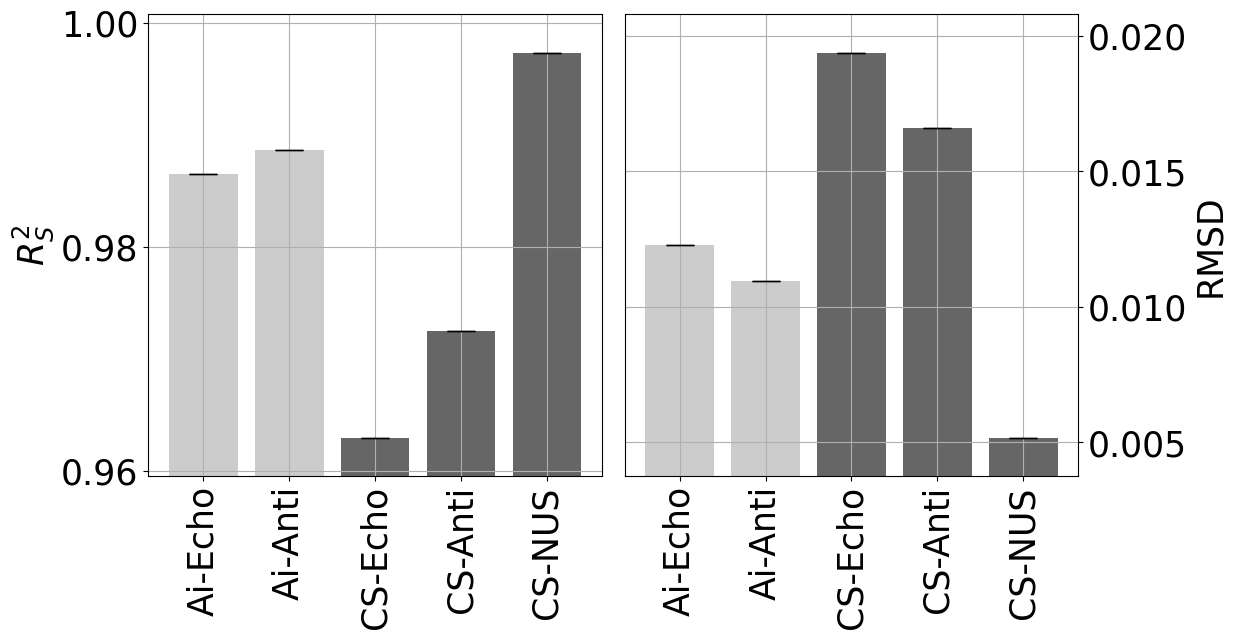

In [9]:
%%time
threshold = 0.01
threshold_up = 1
RR_U = np.zeros((5,1))
RMSD_U = np.zeros((5,1))
for j in range(1):
    RR_U[0,j], RMSD_U[0,j] = pr.metric.CC_RMSD(Ref_R,WNN_Echo_R,threshold,threshold_up)
    RR_U[1,j], RMSD_U[1,j] = pr.metric.CC_RMSD(Ref_R,WNN_Anti_R,threshold,threshold_up)
    RR_U[2,j], RMSD_U[2,j] = pr.metric.CC_RMSD(Ref_R,CS_Echo_R,threshold,threshold_up)
    RR_U[3,j], RMSD_U[3,j] = pr.metric.CC_RMSD(Ref_R,CS_Anti_R,threshold,threshold_up)
    RR_U[4,j], RMSD_U[4,j] = pr.metric.CC_RMSD(Ref_R,CS_NUS_R,threshold,threshold_up)

Label = ['Ai-Echo','Ai-Anti','CS-Echo','CS-Anti','CS-NUS']
color = ['0.8','0.8','0.4','0.4','0.4']    

pr.PLOTS.CC_RMSD_plt(Label,RR_U,RMSD_U,color)